# 

# Denoising Experiement 

In [9]:
import sys 
sys.path.append("../")

import torch 
import torch.nn
from torchsummary import summary

from Conv1d_NN import Conv1d_NN
from Conv2d_NN import Conv2d_NN

from models import * 
from train import * 
from dataset import * 
from pixelshuffle import * 

### Get Data

In [10]:
# Noisy Data
noisy_dataset = MNIST1D_Dataset()
print(noisy_dataset.data_args.iid_noise_scale, noisy_dataset.data_args.corr_noise_scale)
noisy_data = noisy_dataset.make_dataset()


# Clean Data 
clean_dataset = MNIST1D_Dataset()
clean_dataset.data_args.iid_noise_scale = 0.0
clean_dataset.data_args.corr_noise_scale = 0.0
print(clean_dataset.data_args.iid_noise_scale, clean_dataset.data_args.corr_noise_scale)

clean_data = clean_dataset.make_dataset()


0.02 0.25
0.0 0.0


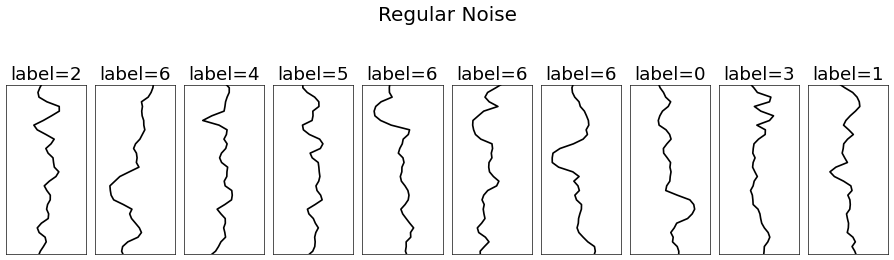

In [11]:
Plot = MNIST1D_Plot()

# Noisy Data
Plot.plot_signals(noisy_data['x'][:10], noisy_data['t'], labels=noisy_data['y'][:10], zoom = 5, title='Regular Noise')


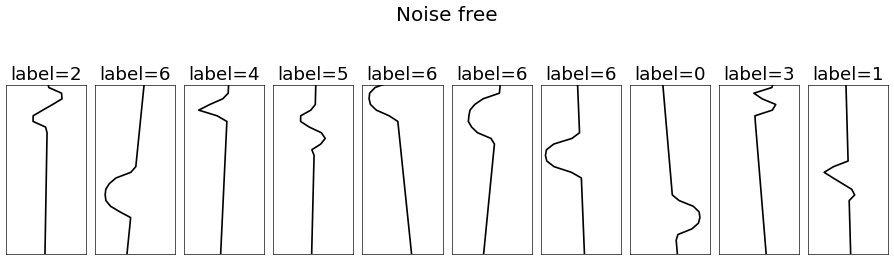

In [4]:
# Clean Data
Plot.plot_signals(clean_data['x'][:10], clean_data['t'], labels=clean_data['y'][:10], zoom = 5, title='Noise free')


### U Net Model

In [15]:
UNet_Denoiser = nn.Sequential(
   # Initial Increase in channels 
   Conv1d_NN(in_channels= 1, out_channels=16, K=5, stride=5), 
   nn.ReLU(), 
   
   # Unshuffling
   PixelUnshuffle1D(2), 
   Conv1d_NN(in_channels=32, out_channels=32, K=5, stride=5), 
   nn.ReLU(), 
   PixelUnshuffle1D(2), 
   Conv1d_NN(in_channels=64, out_channels=64, K=5, stride=5), 
   nn.ReLU(), 
   PixelUnshuffle1D(2), 
   Conv1d_NN(in_channels=128, out_channels=128, K=5, stride=5), 
   nn.ReLU(), 
   
   # Shuffling 
   PixelShuffle1D(2), 
   Conv1d_NN(in_channels=64, out_channels=64, K=5, stride=5), 
   nn.ReLU(), 
   PixelShuffle1D(2), 
   Conv1d_NN(in_channels=32, out_channels=32, K=5, stride=5), 
   nn.ReLU(), 
   PixelShuffle1D(2), 
   Conv1d_NN(in_channels=16, out_channels=16, K=5, stride=5), 
   nn.ReLU(), 
   nn.Conv1d(in_channels=16, out_channels= 1, kernel_size=1)
   
)

# Get summary 
from torchsummary import summary 
summary(UNet_Denoiser, (1, 40))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 16, 40]              96
              ReLU-2               [-1, 16, 40]               0
         Conv1d_NN-3               [-1, 16, 40]               0
              ReLU-4               [-1, 16, 40]               0
  PixelUnshuffle1D-5               [-1, 32, 20]               0
            Conv1d-6               [-1, 32, 20]           5,152
              ReLU-7               [-1, 32, 20]               0
         Conv1d_NN-8               [-1, 32, 20]               0
              ReLU-9               [-1, 32, 20]               0
 PixelUnshuffle1D-10               [-1, 64, 10]               0
           Conv1d-11               [-1, 64, 10]          20,544
             ReLU-12               [-1, 64, 10]               0
        Conv1d_NN-13               [-1, 64, 10]               0
             ReLU-14               [-1,

In [16]:
# UNet_Denoiser results 
print("UNet Denoiser Results: \n")
UNet_Denoiser_results = train_model_denoise(noisy_data, clean_data, UNet_Denoiser, noisy_dataset.model_args)


UNet Denoiser Results: 

step 1000, dt 44.51s, train_loss 2.746e-01, test_loss 2.457e-01, train_acc 6.4, test_acc 6.1
step 2000, dt 40.62s, train_loss 2.214e-01, test_loss 2.419e-01, train_acc 6.8, test_acc 6.2
step 3000, dt 39.06s, train_loss 2.440e-01, test_loss 2.591e-01, train_acc 6.5, test_acc 5.9
step 4000, dt 42.76s, train_loss 2.299e-01, test_loss 2.399e-01, train_acc 7.1, test_acc 6.2
step 5000, dt 44.47s, train_loss 2.251e-01, test_loss 2.502e-01, train_acc 6.9, test_acc 6.0
step 6000, dt 38.69s, train_loss 2.272e-01, test_loss 2.521e-01, train_acc 6.9, test_acc 6.0


Original Input


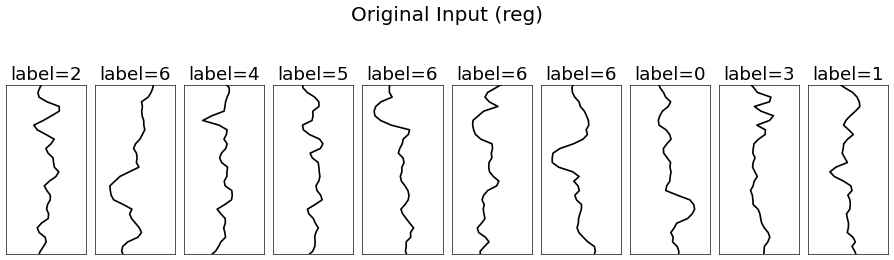

Target Output


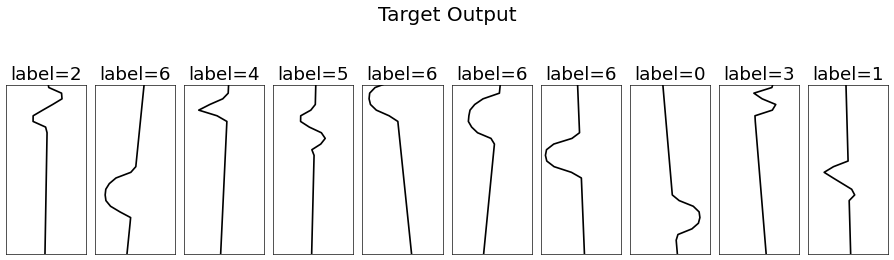

Prediction


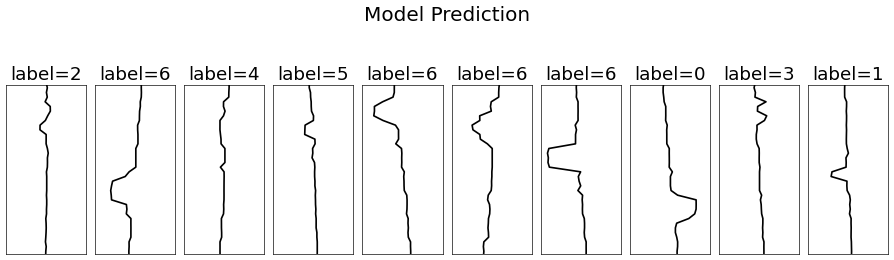

In [18]:
UNet_sample = noisy_data['x'][:10].to('mps')

UNet_Denoiser = UNet_Denoiser.to('mps')

UNet_output = UNet_Denoiser(UNet_sample)
UNet_output = UNet_output.detach().cpu().numpy()

# Original Input 
print("Original Input")
Plot.plot_signals(noisy_data['x'][:10], noisy_data['t'], labels=noisy_data['y'][:10], zoom = 5, title='Original Input (reg)')

# Target 
print("Target Output")
Plot.plot_signals(clean_data['x'][:10], clean_data['t'], labels=clean_data['y'][:10], zoom = 5, title='Target Output')

# Model Prediction
print("Prediction")
Plot.plot_signals(UNet_output, noisy_data['t'], labels=noisy_data['y'][:10], zoom = 5, title='Model Prediction')

In [6]:
UNet_Denoiser1 = UNet_Denoiser()

# UNet_Denoiser results 
print("UNet Denoiser1 Results: \n")
UNet_Denoiser_results = train_model_denoise(noisy_data, clean_data, UNet_Denoiser1, noisy_dataset.model_args)



UNet Denoiser1 Results: 

step 1000, dt 80.26s, train_loss 1.073e+00, test_loss 1.019e+00, train_acc 0.0, test_acc -0.1
step 2000, dt 76.36s, train_loss 1.074e+00, test_loss 1.019e+00, train_acc 0.0, test_acc -0.1
step 3000, dt 77.50s, train_loss 1.074e+00, test_loss 1.019e+00, train_acc 0.0, test_acc -0.1
step 4000, dt 78.08s, train_loss 1.074e+00, test_loss 1.019e+00, train_acc 0.0, test_acc -0.1
step 5000, dt 78.57s, train_loss 1.074e+00, test_loss 1.019e+00, train_acc 0.0, test_acc -0.1
step 6000, dt 78.57s, train_loss 1.074e+00, test_loss 1.019e+00, train_acc 0.0, test_acc -0.1


Original Input


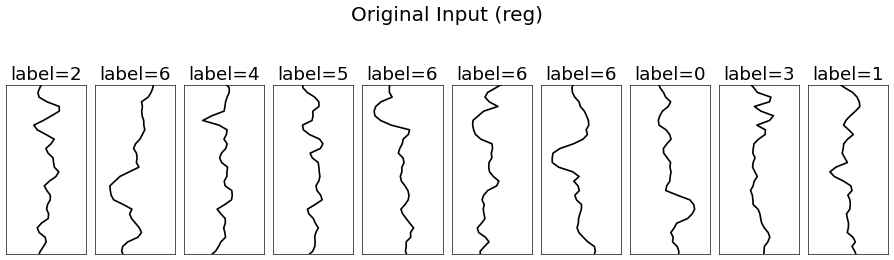

Target Output


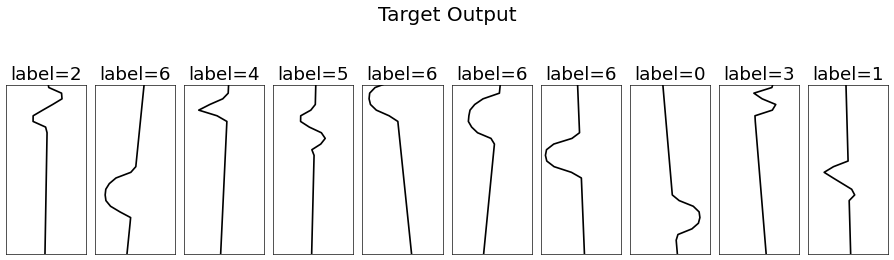

Prediction


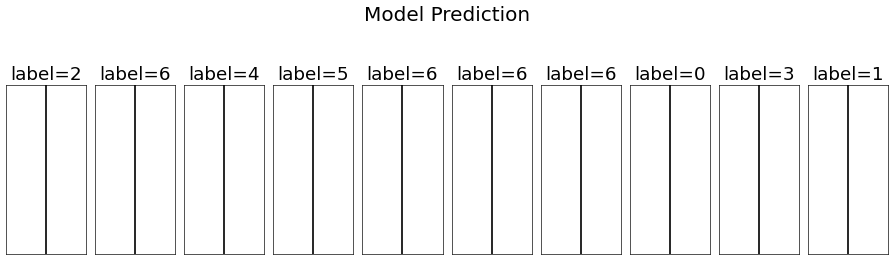

In [12]:
UNet_sample = noisy_data['x'][:10].to('mps')

UNet_Denoiser1 = UNet_Denoiser1.to('mps')

UNet_output = UNet_Denoiser1(UNet_sample)
UNet_output = UNet_output.detach().cpu().numpy()

# Original Input 
print("Original Input")
Plot.plot_signals(noisy_data['x'][:10], noisy_data['t'], labels=noisy_data['y'][:10], zoom = 5, title='Original Input (reg)')

# Target 
print("Target Output")
Plot.plot_signals(clean_data['x'][:10], clean_data['t'], labels=clean_data['y'][:10], zoom = 5, title='Target Output')

# Model Prediction
print("Prediction")
Plot.plot_signals(UNet_output, noisy_data['t'], labels=noisy_data['y'][:10], zoom = 5, title='Model Prediction')

### Branching model

In [10]:
branching_denoiser = nn.Sequential(
   BranchingNetwork(in_ch = 1, out_ch1 = 16, out_ch2=16, kernel_size = 3), 
   BranchingNetwork(in_ch = 16, out_ch1 = 8, out_ch2=8, kernel_size = 3),
   BranchingNetwork(in_ch = 8, out_ch1 = 4, out_ch2=4, kernel_size =3), 
   BranchingNetwork(in_ch = 4, out_ch1 = 2, out_ch2=2, kernel_size =3), 
   BranchingNetwork(in_ch = 2, out_ch1 = 1, out_ch2=1, kernel_size =3) 
)

summary(branching_denoiser, (1, 40))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 16, 38]              64
              ReLU-2               [-1, 16, 38]               0
            Conv1d-3               [-1, 16, 40]              64
              ReLU-4               [-1, 16, 40]               0
         Conv1d_NN-5               [-1, 16, 40]               0
              ReLU-6               [-1, 16, 40]               0
            Conv1d-7               [-1, 16, 40]             528
  BranchingNetwork-8               [-1, 16, 40]               0
            Conv1d-9                [-1, 8, 38]             392
             ReLU-10                [-1, 8, 38]               0
           Conv1d-11                [-1, 8, 40]             392
             ReLU-12                [-1, 8, 40]               0
        Conv1d_NN-13                [-1, 8, 40]               0
             ReLU-14                [-1

In [11]:
# Branchin_denoiser results 
print("Branching Denoiser Results: \n")
Branching_denoiser_results = train_model_denoise(noisy_data, clean_data, branching_denoiser, noisy_dataset.model_args)

Branching Denoiser Results: 

step 1000, dt 42.01s, train_loss 1.988e-01, test_loss 1.954e-01, train_acc 7.3, test_acc 7.1
step 2000, dt 41.43s, train_loss 1.769e-01, test_loss 1.768e-01, train_acc 7.7, test_acc 7.5
step 3000, dt 40.80s, train_loss 1.762e-01, test_loss 1.733e-01, train_acc 7.8, test_acc 7.6
step 4000, dt 37.61s, train_loss 1.753e-01, test_loss 1.699e-01, train_acc 7.9, test_acc 7.7
step 5000, dt 32.84s, train_loss 1.711e-01, test_loss 1.671e-01, train_acc 8.0, test_acc 7.8
step 6000, dt 33.52s, train_loss 1.663e-01, test_loss 1.626e-01, train_acc 8.1, test_acc 7.9


Original Input


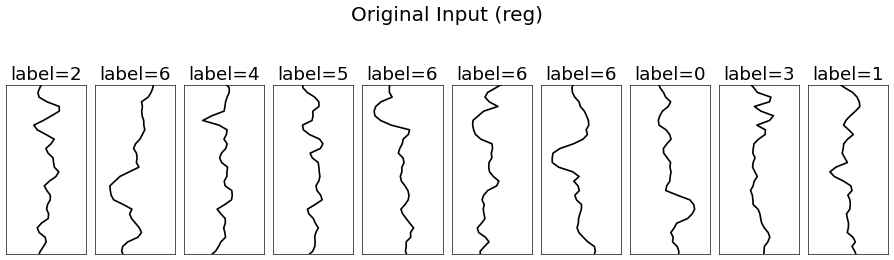

Target Output


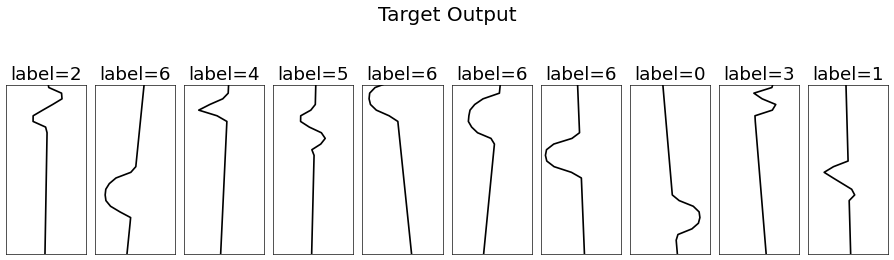

Prediction


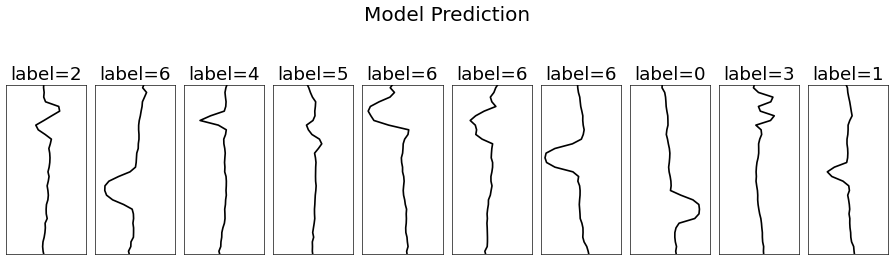

In [12]:
branching_sample = noisy_data['x'][:10].to('mps')

branching_denoiser = branching_denoiser.to('mps')

branching_output = branching_denoiser(branching_sample)
branching_output = branching_output.detach().cpu().numpy()

# Original Input 
print("Original Input")
Plot.plot_signals(noisy_data['x'][:10], noisy_data['t'], labels=noisy_data['y'][:10], zoom = 5, title='Original Input (reg)')

# Target 
print("Target Output")
Plot.plot_signals(clean_data['x'][:10], clean_data['t'], labels=clean_data['y'][:10], zoom = 5, title='Target Output')

# Model Prediction
print("Prediction")
Plot.plot_signals(branching_output, noisy_data['t'], labels=noisy_data['y'][:10], zoom = 5, title='Model Prediction')

### Regular CNN Model

In [13]:
reg_denoiser = ConvDenoiser() 

summary(reg_denoiser, (1, 40))

Initialized ConvDenoiser model with 5505 parameters
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 40]             192
            Conv1d-2               [-1, 32, 40]           5,152
            Conv1d-3                [-1, 1, 40]             161
Total params: 5,505
Trainable params: 5,505
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.02
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


In [14]:
# Regular CNN results 
print("Regular CNN Denoiser Results: \n")
reg_cnn_denoiser_results = train_model_denoise(noisy_data, clean_data, reg_denoiser, noisy_dataset.model_args)

Regular CNN Denoiser Results: 

step 1000, dt 3.57s, train_loss 6.507e-01, test_loss 6.064e-01, train_acc 2.3, test_acc 2.2
step 2000, dt 2.64s, train_loss 6.453e-01, test_loss 6.035e-01, train_acc 2.3, test_acc 2.2
step 3000, dt 2.51s, train_loss 6.428e-01, test_loss 6.019e-01, train_acc 2.4, test_acc 2.2
step 4000, dt 2.53s, train_loss 6.421e-01, test_loss 6.014e-01, train_acc 2.4, test_acc 2.2
step 5000, dt 2.47s, train_loss 6.414e-01, test_loss 6.033e-01, train_acc 2.4, test_acc 2.2
step 6000, dt 2.55s, train_loss 6.414e-01, test_loss 6.016e-01, train_acc 2.4, test_acc 2.2


Original Input


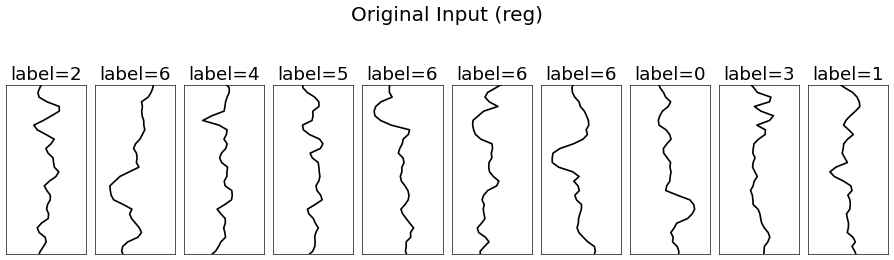

Target Output


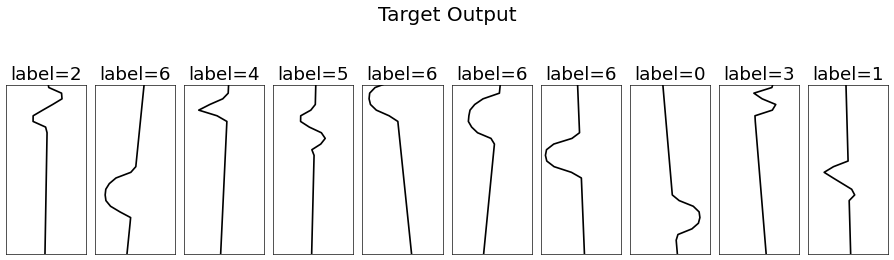

Prediction


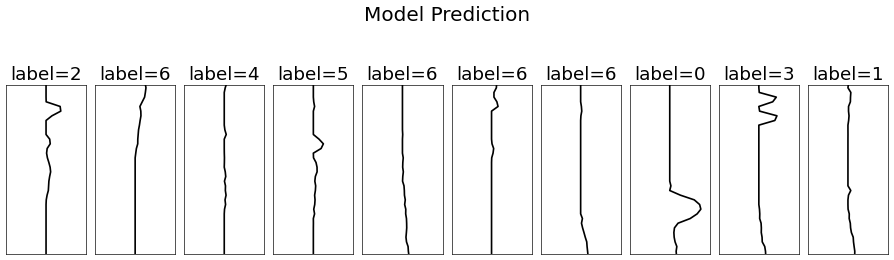

In [17]:
reg_sample = noisy_data['x'][:10].to('mps')

reg_denoiser = reg_denoiser.to('mps')

reg_output = reg_denoiser(reg_sample)
reg_output = reg_output.detach().cpu().numpy()

# Original Input 
print("Original Input")
Plot.plot_signals(noisy_data['x'][:10], noisy_data['t'], labels=noisy_data['y'][:10], zoom = 5, title='Original Input (reg)')

# Target 
print("Target Output")
Plot.plot_signals(clean_data['x'][:10], clean_data['t'], labels=clean_data['y'][:10], zoom = 5, title='Target Output')

# Model Prediction
print("Prediction")
Plot.plot_signals(reg_output, noisy_data['t'], labels=noisy_data['y'][:10], zoom = 5, title='Model Prediction')